In [12]:
import pandas as pd


ds_json = pd.read_json('data/lorawan_antwerp_2019_dataset.json')
gw_loc = pd.read_json('data/lorawan_antwerp_gateway_locations.json')

In [13]:
ds_json

,adr,hdop,counter,longitude,sf,airtime,dev_addr,gateways,latitude,dev_eui,payload,channel
0,1,0.66,100086,4.427051,7,0.112896,07000EFF,"[{'id': '080605EE', 'rssi': -104, 'snr': -3.25...",51.235508,343233386A377C18,00eb000329f14c4267aa8d40c3f5283f0400ca55410510...,6
1,1,0.83,62377,4.397273,7,0.112896,07000EAD,"[{'id': '08060716', 'rssi': -99, 'snr': 10.0, ...",51.203171,3432333855378A18,003900030cd04c4276b68c40e17a543f048051bf4105c0...,8
2,1,0.70,31952,4.400576,7,0.112896,07000EFE,"[{'id': '08060716', 'rssi': -115, 'snr': 6.75,...",51.208565,3432333853376B18,008d000392d54c4284d18c403333333f04682aa9410500...,8
3,1,0.64,57377,4.391779,7,0.112896,07000FB2,"[{'id': 'FF0178DF', 'rssi': -85, 'snr': -5.0, ...",51.202320,3432333864377C18,00c300032dcf4c4275898c400bd7233f0430896b410540...,3
4,1,0.64,112480,4.417615,8,0.205312,07000ECB,"[{'id': 'FF0107C9', 'rssi': -114, 'snr': -4.0,...",51.211182,3432333855376418,00f6000340d84c421a5d8d400bd7233f040832bb4105a0...,7
...,...,...,...,...,...,...,...,...,...,...,...,...
130425,1,0.67,84868,4.409659,7,0.112896,07000FB2,"[{'id': 'FF0107C9', 'rssi': -110, 'snr': 3.0, ...",51.220184,3432333864377C18,001c000378e14c42ed1b8d401f852b3f04909688410570...,5
130426,1,0.72,35,4.418367,7,0.112896,07000EFD,"[{'id': '080E00B9', 'rssi': -103, 'snr': 10.25...",51.194546,3432333860376818,0021000337c74c4244638d40eb51383f04e8be0f420540...,8
130427,1,0.72,84867,4.409659,7,0.112896,07000FB2,"[{'id': 'FF0107C9', 'rssi': -105, 'snr': 1.0, ...",51.220184,3432333864377C18,001b000378e14c42ee1b8d40eb51383f046059874105b0...,3
130428,1,0.73,88640,4.409161,7,0.112896,07000EAD,"[{'id': 'FF010560', 'rssi': -114, 'snr': -8.0,...",51.233089,3432333855378A18,00d30003afee4c42d8178d4047e13a3f04d83baa410520...,1


In [14]:
gw_meta = ds_json.latitude

In [15]:
gw_meta[1]

51.20317077636719

In [16]:
# Loading initial position coordinates form machine learning predictions
pos_pred_rssi = pd.read_csv('files/position_pred_RSSI.csv', index_col=0)
pos_pred_comb = pd.read_csv('files/position_pred_weather-comb.csv', index_col=0)

import pymap3d as pm 

pos_pred_rssi['x'], pos_pred_rssi['y'], _ = pm.geodetic2ecef(lat=pos_pred_rssi['lat'], lon=pos_pred_rssi['lon'], alt=0)
pos_pred_rssi['x_i'], pos_pred_rssi['y_i'], _ = pm.geodetic2ecef(lat=pos_pred_rssi['pred_lat_rssi'], lon=pos_pred_rssi['pred_lon_rssi'], alt=0)

pos_pred_comb['x'], pos_pred_comb['y'], _ = pm.geodetic2ecef(lat=pos_pred_comb['lat'], lon=pos_pred_comb['lon'], alt=0)
pos_pred_comb['x_i'], pos_pred_comb['y_i'], _ = pm.geodetic2ecef(lat=pos_pred_comb['pred_lat_comb'], lon=pos_pred_comb['pred_lon_comb'], alt=0)


The idea is to <input type="checkbox" enabled> accumulate the actual lat-lon data, predicted ones, the converted lat-lon values, including the lat-lon vlaues for initialization (these initial values are the converted location values predicted by the machine learning model) into a single dataframe and file.

Later

<input type="checkbox" enabled> 1. we will pick each sample from this locaiton dataset, 

<input type="checkbox" enabled> 2. take the timestamp values from the sample 

<input type="checkbox" enabled> 3. Find the corresponding data point from the ds_json raw data collection 

<input type="checkbox" enabled> 4. Get the corresponding GW metadata from the Gateways column

<input type="checkbox" enabled> 5. collect the TOA values for each GW and their GWID

<input type="checkbox" enabled> 6. We will get the lat-lon of the corresponding GW in the gw_loc df and convert it to ecef 

<input type="checkbox" enabled> 7. Do the position estimation

<input type="checkbox" enabled> 8. Compare the ecef coordinates with the actual values 

<input type="checkbox" enabled> 9. Finally, convert to the geodetic coordinate and calculate the defference/error '   


In [17]:
pos_pred_rssi.to_csv('files/pos_pred_rssi_ecef.csv')
pos_pred_comb.to_csv('files/pos_pred_comb_ecef.csv')

In [18]:
pos_pred_comb

,lat,lon,pred_lat_comb,pred_lon_comb,x,y,x_i,y_i
0,51.230606,4.413290,51.232580,4.410972,3.990194e+06,307959.712516,3.990036e+06,307785.167789
1,51.194290,4.418983,51.194305,4.418989,3.993303e+06,308598.861497,3.993302e+06,308599.158375
2,51.205948,4.418719,51.206895,4.424487,3.992297e+06,308502.609403,3.992184e+06,308898.190332
3,51.230633,4.402852,51.223873,4.412511,3.990248e+06,307232.608546,3.990781e+06,307950.421052
4,51.194073,4.418471,51.194076,4.418451,3.993325e+06,308564.653922,3.993325e+06,308563.197832
...,...,...,...,...,...,...,...,...
8302,51.202583,4.407392,51.205009,4.409659,3.992649e+06,307735.719790,3.992427e+06,307877.557610
8303,51.233234,4.405138,51.234394,4.407528,3.990011e+06,307374.508929,3.989897e+06,307533.188379
8304,51.234436,4.411942,51.234444,4.411939,3.989870e+06,307840.343308,3.989869e+06,307840.068152
8305,51.231110,4.411080,51.228693,4.420569,3.990162e+06,307802.467532,3.990320e+06,308479.422854


## Foy's algorithm  

    Estimates the position using TDOA and Taylor-series estimation.
    
    Parameters:
    - initial_coords: Initial guess for the target node's coordinates [x, y].
    - gateway_coords: Coordinates of the gateways as a list of [x, y] pairs.
    - tdoa_values: Measured TDOA values between each pair of gateways.
    - max_iterations: Maximum number of iterations for convergence.
    - tolerance: Convergence tolerance for the position updates.
    
    Returns:
    - Estimated coordinates [x, y].

### Example usage:
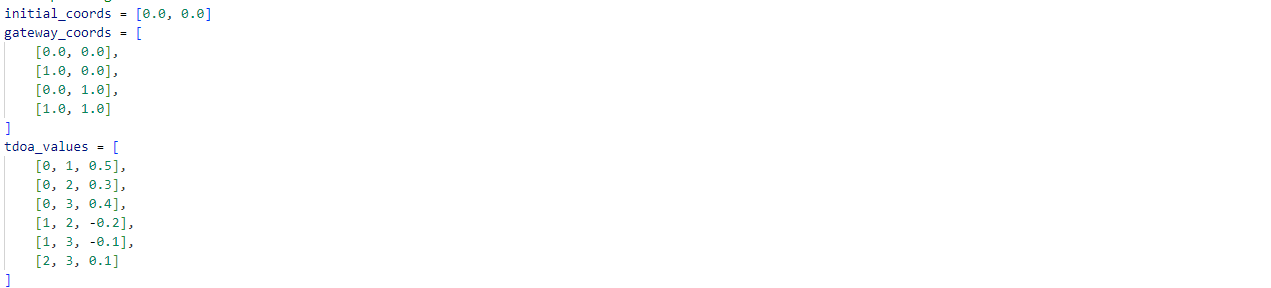

In [ ]:
# from foys_alg import tdoa_position_estimation

for i in range(len(pos_pred_comb)):
    current_sample = pos_pred_comb.iloc[i] 
    # collecting the initial coorinates for estiamtion. These initial coordinates are the prediction of our ML model  
    init_cord = [current_sample['x_i'], current_sample['y_i']]

    # Collecting the GW coordinates  
    # getting the corresponding sample from ds_json: matching with the actual coordinates from the location data
    raw_data_sample = ds_json[(ds_json['latitude']==current_sample['lat']) & (ds_json['longitude']==current_sample['lon'])]
    
    

    # foy_estimation = tdoa_position_estimation(init_cord,  )

In [21]:
pos_pred_comb.iloc[1]['lat']

51.1942901611328

In [29]:
raw_data_sample = ds_json[(ds_json['latitude']==pos_pred_comb.iloc[7]['lat']) & (ds_json['longitude']==pos_pred_comb.iloc[7]['lon'])]

raw_data_sample

,adr,hdop,counter,longitude,sf,airtime,dev_addr,gateways,latitude,dev_eui,payload,channel


In [30]:
pos_pred_comb.iloc[7]['lon']

4.41877126693726

In [33]:
ds_json[ds_json['longitude']==pos_pred_comb.iloc[9]['lon']]

,adr,hdop,counter,longitude,sf,airtime,dev_addr,gateways,latitude,dev_eui,payload,channel


In [34]:
ds_csv = pd.read_csv('data/antwerp_ds_weather-data_2019.csv', index_col=0)

In [36]:
ds_csv['RX Time']

0               2019-01-11T11:27:31.534+01:00
1               2019-01-15T09:55:04.560+01:00
2               2019-01-03T12:06:00.983+01:00
3         2019-01-23T08:13:58.520215889+01:00
4         2019-01-29T17:20:20.826210335+01:00
                         ...                 
130424          2019-01-06T09:50:18.903+01:00
130425    2019-01-23T13:12:13.537271497+01:00
130426          2019-01-08T12:40:25.008+01:00
130427    2019-01-23T10:19:55.398680312+01:00
130428          2018-12-31T08:38:49.845+01:00
Name: RX Time, Length: 130429, dtype: object

In [38]:
print(type(ds_csv['RX Time'][1]))

<class 'str'>
